## Summary: Systematic effects on Edelweiss C

One wonders if a different estimate on the widening necessary for the nuclear-recoil band would happen if there were systematic errors on e.g. the recorded voltage on the detector.

This notebook examines the effect of possible systematics on C.

In [2]:
import numpy as np
import pandas as pd
from joblib import Memory
import matplotlib.pyplot as plt
%matplotlib inline 

from scipy import optimize
import lmfit as lmf

import sys
sys.path.append('../python/')
from EdwRes import *
from prob_dist import *

In [3]:
# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
aH = 0.0157
pars = {
    'V' : 4.0,
    'eps_eV' : 3.0
    }

## Only the ratio of V/$\epsilon$ matters

In the Edelweiss expression for the yield width, V and $\epsilon$ always appear as a ratio.

Therefore, our answer is sensitivity to the uncertainty in $V/\epsilon$, not the uncertainty of $V$ and $\epsilon$ separately.

In [22]:
sig_nr_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                   pars, \
                                   aH=0.03808*FWHM_to_SIG, C=0.03132, m=0.00013)

sig_nr_func_V = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                     {'V': 4.0*1.5, 'eps_eV': 3.0}, \
                                     aH=0.03808*FWHM_to_SIG, C=0.03132, m=0.00013)

sig_nr_func_eps = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                     {'V': 4.0, 'eps_eV': 3.0/1.5}, \
                                     aH=0.03808*FWHM_to_SIG, C=0.03132, m=0.00013)

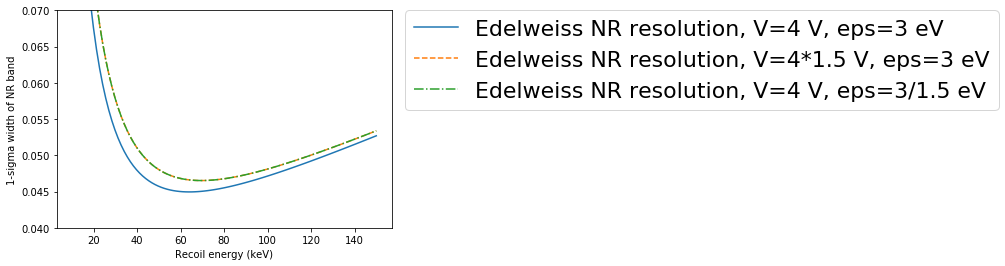

In [27]:
E_recoil_arr = np.linspace(10, 150, 100)

plt.plot(E_recoil_arr, sig_nr_func(E_recoil_arr), label="Edelweiss NR resolution, V=4 V, eps=3 eV")
plt.plot(E_recoil_arr, sig_nr_func_5V(E_recoil_arr), '--', label="Edelweiss NR resolution, V=4*1.5 V, eps=3 eV")
plt.plot(E_recoil_arr, sig_nr_func_3V(E_recoil_arr), '-.', label="Edelweiss NR resolution, V=4 V, eps=3/1.5 eV")

plt.xlabel("Recoil energy (keV)")
plt.ylabel("1-sigma width of NR band")
plt.ylim(0.04, 0.07)

ax1 = plt.gca()
ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

In [4]:
# import data from Edelweiss
resNR_data = pd.read_csv("data/edelweiss_NRwidth_GGA3_data.txt", skiprows=1, \
                       names=['E_recoil', 'sig_NR', 'E_recoil_err', 'sig_NR_err'], \
                       delim_whitespace=True)

resER_data = pd.read_csv("data/edelweiss_ERwidth_GGA3_data.txt", skiprows=1, \
                         names=['E_recoil', 'sig_ER', 'sig_ER_err'], \
                         delim_whitespace=True)

#print (res_data.head(4))

# set the data up for the fits
# Edelweiss discards ER points near peaks
# and first two NR points since they're affected by the threshold
mask = [True, True, False, False, True, True, True, True, True]
ER_data = {'Erecoil': resER_data["E_recoil"][mask], 'sigma': resER_data["sig_ER"][mask], 'sigma_err': resER_data["sig_ER_err"][mask]}
NR_data = {'Erecoil': resNR_data["E_recoil"][2::], 'sigma': resNR_data["sig_NR"][2::], 'sigma_err': resNR_data["sig_NR_err"][2::]}